In [1]:
import argparse
import re
import networkx as nx
import scipy as scipy
import matplotlib.pyplot as plt # for visualizing GMLs
import os
import itertools
%matplotlib inline
import pandas as pd

In [2]:
# Mapping Clusters of Orthologous Genes (COGs) between two pan-genome gene graphs

In [3]:
def conv_list(maybe_list):
    if not isinstance(maybe_list, list):
        maybe_list = [maybe_list]
    return (maybe_list)

def update_sid(sid, member_count):
    sid = sid.split("_")
    sid[0] = str(member_count + int(sid[0].replace("'", "")))
    return ("_".join(sid))

def del_dups(iterable):
    seen = {}
    for f in iterable:
        seen[f] = None
    return (list(seen.keys()))

def load_graphs(graph_files, n_cpu=1):
    for graph_file in graph_files:
        if not os.path.isfile(graph_file):
            print("Missing:", graph_file)
            raise RuntimeError("Missing graph file!")

    graphs = [nx.read_gml(graph_file) for graph_file in graph_files]
    isolate_names = list(
        itertools.chain.from_iterable(
            [G.graph['isolateNames'] for G in graphs]))

    member_count = 0
    node_count = 0
    id_mapping = []
    for i, G in enumerate(graphs):
        id_mapping.append({})
        # relabel nodes to be consecutive integers from 1
        mapping = {}
        for n in G.nodes():
            mapping[n] = node_count
            node_count += 1
        G = nx.relabel_nodes(G, mapping, copy=True)

        # set up edge members and remove conflicts.
        for e in G.edges():
            G[e[0]][e[1]]['members'] = [
                m + member_count for m in conv_list(G[e[0]][e[1]]['members'])
            ]

        # set up node parameters and remove conflicts.
        max_mem = -1
        for n in G.nodes():
            ncentroids = []
            for sid in G.nodes[n]['centroid'].split(";"):
                nid = update_sid(sid, member_count)
                id_mapping[i][sid] = nid
                if "refound" not in nid:
                    ncentroids.append(nid)
            G.nodes[n]['centroid'] = ncentroids
            new_ids = set()
            for sid in conv_list(G.nodes[n]['seqIDs']):
                nid = update_sid(sid, member_count)
                id_mapping[i][sid] = nid
                new_ids.add(nid)
            G.nodes[n]['seqIDs'] = new_ids
            G.nodes[n]['protein'] = del_dups(G.nodes[n]['protein'].replace(
                '*', 'J').split(";"))
            G.nodes[n]['dna'] = del_dups(G.nodes[n]['dna'].split(";"))
            G.nodes[n]['lengths'] = conv_list(G.nodes[n]['lengths'])
            G.nodes[n]['longCentroidID'][1] = update_sid(
                G.nodes[n]['longCentroidID'][1], member_count)
            G.nodes[n]['members'] = [m + member_count for m in conv_list(G.nodes[n]['members'])]
            max_mem = max(max_mem, max(G.nodes[n]['members']))

        member_count = max_mem + 1
        graphs[i] = G

    return graphs, isolate_names, id_mapping

In [4]:
### read in two graphs

# old method, does not read in metadata
#sim_graph_04 = nx.read_gml("../../graph_1/final_graph.gml")
#sim_graph_59 = nx.read_gml("../../graph_2/final_graph.gml")
#list(sim_graph_04.nodes(data=True))

# new method:
graph_files = ["../../graph_1/final_graph.gml", "../../graph_2/final_graph.gml"]

graphs, isolate_names, id_mapping = load_graphs(graph_files)

sim_graph_04 = graphs[0]
sim_graph_59 = graphs[1]

print(sim_graph_04)
print(sim_graph_59)

list(sim_graph_04.nodes(data=True))

Graph with 257 nodes and 314 edges
Graph with 269 nodes and 332 edges


[(0,
  {'size': 1,
   'centroid': ['0_0_10'],
   'maxLenId': 0,
   'members': [0],
   'seqIDs': {'0_0_10'},
   'hasEnd': 0,
   'protein': ['MRKSLKGEKVSNKQIAIMMATYNGAKYIGEQIDSILRQTYQDWKLFIHDDCSNDATFQILQQYQEKYPKKIKVITDSSVIGGSSEKNFAAIQKWVTNNHDFSYFMFADQDDFWFPNKIERSLYKMKESEKDDLPILVHTDLEVVDDNLNIINDSFFEYRALDVDVTELNRILIQNNITGCTMLWNRSLNNLLDLNSNAVAMHDWWISLVAASFGKIVCLKEPTIKYRQHGGNVVGATQVNTLGFIIKRLLGNSHVKETLKLSFEQAESFLKVYQNSLSNEETDIIREFISIPHKHKLARISTVIKGGYLKQSVVQVIGELMFI'],
   'dna': ['ATGAGGAAGAGTTTGAAGGGGGAAAAAGTGAGTAACAAGCAAATTGCGATTATGATGGCAACTTATAATGGAGCTAAATACATTGGAGAACAGATAGACTCTATTCTTAGGCAAACTTATCAAGATTGGAAATTATTTATCCATGACGATTGTTCAAATGATGCTACTTTTCAAATCCTTCAGCAATACCAAGAAAAATACCCTAAAAAAATTAAGGTTATCACAGATTCCTCTGTTATAGGGGGGAGCTCAGAGAAAAATTTTGCAGCTATTCAAAAATGGGTGACGAATAATCATGATTTTTCTTATTTTATGTTTGCAGATCAAGATGATTTTTGGTTTCCAAATAAGATTGAGCGCTCACTTTATAAAATGAAAGAATCAGAAAAGGATGATTTACCTATTTTAGTTCATACTGATTTAGAAGTTGTTGATGATAATTTAAATATAATTAACGATTCTTTCTTCGAATATCGTGCCTTAGATGTAGATGTGACAGAATTGAATCGTATACTTATACA

In [5]:
### map nodes from ggcaller graphs to the COG labels in the centroid from pangenome

# read into df
# each "group_" refers to the centroid of that group in the pan_genomes_reference.fa
mmseqs = pd.read_csv('../../graph_merged/mmseqs_alignments.m8', sep='\t')

In [6]:
### match individual panaroo groups
# for this, change the second graph node names to the first graph node names for nodes that match according to mmseqs

# have to make some decisions here:
# if two separate groups in target match to one group in query, do we:
# a) merge all groups into one
# b) perform some other clustering qc step to determine whether to group them all or split the query group in two
# for now, we'll group them all together

# if one group in target matches to multiple groups in query:
# for now, pick the best match

# only keep nodes with a fraction of identical matches (fident) >=0.7:
#mmseq = mmseqs["fident"] >= 0.7 
mmseq = mmseqs["fident"] >= 0.98 


# iterate over target with each unique value of target, and pick the match with the highest fident; if multiple, pick the one with the smaller E value

# make sure fident is numeric
mmseqs["fident"] = pd.to_numeric(mmseqs["fident"], errors='coerce')
mmseqs["evalue"] = pd.to_numeric(mmseqs["evalue"], errors='coerce')

# sort by fident (highest first) and evalue (lowest first)
mmseqs_sorted = mmseqs.sort_values(by=["fident", "evalue"], ascending=[False, True])

# only keep the first occurrence per unique target (highest fident then smallest evalue if tie)
mmseqs_filtered = mmseqs_sorted.groupby("target", as_index=False).first()

# remove "group_" prefix, keep as string
#mmseqs_filtered = mmseqs_filtered.applymap(lambda x: x.replace("group_", "") if isinstance(x, str) else x)

In [7]:
# in mmseqs, the first graph entered (in this case graph_1) is the query and the second entered (in this case graph_2) is the target
# so graph_1 is our query in mmseqs and the basegraph in the tokenized merge

# when iterating over the graph used to append the basegraph (graph_2), we want to match nodes according to their graph_1 identity
# so we first need to replace all graph_2 nodes with graph_1 node ids

### THE NAME ("group_1") AND THE LABEL ('484') ARE DIFFERENT AND A NUMERIC STRING WILL CALL THE LABEL (not index)

mapping_groups_1 = dict()
for node in sim_graph_04.nodes():
    node_group = sim_graph_04.nodes[node].get("name", "error")
    #print(f"graph: 1, node_index_id: {node}, node_group_id: {node_group}")
    mapping_groups_1[int(node)] = str(node_group)

groupmapped_graph_1 = nx.relabel_nodes(sim_graph_04, mapping_groups_1, copy=True)

mapping_groups_2 = dict()
for node in sim_graph_59.nodes():
    node_group = sim_graph_59.nodes[node].get("name", "error")
    #print(f"graph: 1, node_index_id: {node}, node_group_id: {node_group}")
    mapping_groups_2[int(node)] = str(node_group)

groupmapped_graph_2 = nx.relabel_nodes(sim_graph_59, mapping_groups_2, copy=True)

In [8]:
### turn filter set into mapping (dictionary with old labels as keys and new labels as values):

# convert df to dictionary with "target" as keys and "query" as values
mapping = dict(zip(mmseqs_filtered["target"], mmseqs_filtered["query"]))

### to avoid matching nodes from target that have the same group_id but are not the same:
# append all nodes in query graph with _query
# append all query nodes in target graph with _query (for later matching)

mapping = {key: f"{value}_query" for key, value in mapping.items()}

# relabel target graph
relabeled_graph_2 = nx.relabel_nodes(groupmapped_graph_2, mapping, copy=True)

# relabel query graph
mapping_query = dict(zip(groupmapped_graph_1.nodes, groupmapped_graph_1.nodes))
mapping_query = {key: f"{value}_query" for key, value in mapping_query.items()}

relabeled_graph_1 = nx.relabel_nodes(groupmapped_graph_1, mapping_query, copy=True)

### need to do this to edges as well
#print(relabeled_graph_1.edges)
#print(relabeled_graph_2.edges)
# looks like this is done automatically

# now we can modify the tokenized code to iterate like usual, adding new node if string doesn't contain "_query"
# and merging the nodes that both end in "_query"

In [9]:
# to double-check above
if set(relabeled_graph_1.nodes) == set(relabeled_graph_2.nodes):
    print("The node sets are identical.")
else:
    print("The node sets are different.")
    
nodes_1 = set(relabeled_graph_1.nodes)
nodes_2 = set(relabeled_graph_2.nodes)

common_nodes = nodes_1 & nodes_2  # Intersection (nodes in both graphs)
only_in_graph_1 = nodes_1 - nodes_2  # Nodes only in Graph 1
only_in_graph_2 = nodes_2 - nodes_1  # Nodes only in Graph 2

print(f"Common Nodes: {common_nodes}")
print(f"Nodes only in Graph 1: {only_in_graph_1}")
print(f"Nodes only in Graph 2: {only_in_graph_2}")

The node sets are different.
Common Nodes: {'group_219_query', 'group_206_query', 'group_44_query', 'group_160_query', 'group_85_query', 'group_147_query', 'group_67_query', 'group_19_query', 'group_16_query', 'group_176_query', 'group_107_query', 'group_166_query', 'group_51_query', 'group_47_query', 'group_144_query', 'group_114_query', 'group_199_query', 'group_102_query', 'group_187_query', 'group_244_query', 'group_31_query', 'group_143_query', 'group_77_query', 'group_201_query', 'group_183_query', 'group_247_query', 'group_96_query', 'group_79_query', 'group_49_query', 'group_148_query', 'group_218_query', 'group_209_query', 'group_205_query', 'group_197_query', 'group_208_query', 'group_81_query', 'group_132_query', 'group_248_query', 'group_175_query', 'group_153_query', 'group_122_query', 'group_232_query', 'group_100_query', 'group_180_query', 'group_237_query', 'group_154_query', 'group_222_query', 'group_241_query', 'group_171_query', 'group_138_query', 'group_169_query', 

In [ ]:
# !! not needed now that panaroo is run separately !!
# (panaroo standalone outputs "group_x" instead)

# actually still needed to make integers for the run
# this time, only need to remove "group_" from each node

# tokenize clusters by replacing each unique value in the mmseqs alignment output with an integer
# replace query COG names

#unique_clusters_query = alignments['query'].unique()
#alignments['query'].replace(to_replace=unique_clusters_query,
#           value= list(range(len(unique_clusters_query))),
#           inplace=True)

# replace target COG names
#unique_clusters_target = alignments['target'].unique()
#alignments['target'].replace(to_replace=unique_clusters_target,
#           value= list(range(len(unique_clusters_query))),
#           inplace=True)

num nodes (before): 280
num nodes (after): 280
relabeled_graph_2 edges: 321
num edges (before): 461
num edges (after): 461


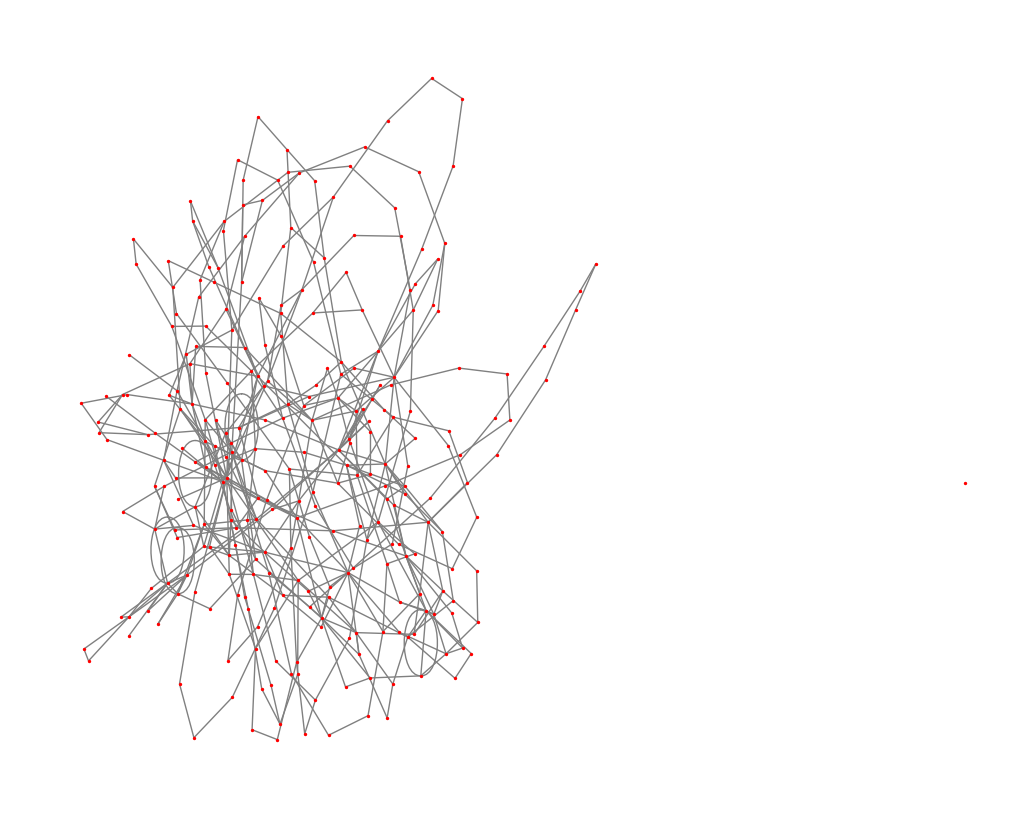

['CR931633_Streptococcus_pneumoniae_strain_pn2L_serotype_2', 'CR931635_Streptococcus_pneumoniae_strain_600_62_serotype_4', 'CR931637_Streptococcus_pneumoniae_strain_Ambrose_serotype_5', 'CR931639_Streptococcus_pneumoniae_strain_2616_39_serotype_6b', 'CR931641_Streptococcus_pneumoniae_strain_Johnson_serotype_7b', 'CR931643_Streptococcus_pneumoniae_strain_554_62_serotype_7f', 'CR931645_Streptococcus_pneumoniae_strain_Wilder_serotype_9a', 'CR931647_Streptococcus_pneumoniae_strain_533_62_serotype_9n', 'CR931649_Streptococcus_pneumoniae_strain_10061_38_serotype_10a', 'CR931651_Streptococcus_pneumoniae_strain_Gro_Norge_serotype_10c', 'CR931653_Streptococcus_pneumoniae_strain_1813_39_serotype_11a', 'CR931655_Streptococcus_pneumoniae_strain_Eddy_nr._53_serotype_11c', 'CR931657_Streptococcus_pneumoniae_strain_34356_serotype_11f', 'CR931659_Streptococcus_pneumoniae_strain_Gambia_1_81_serotype_12b', 'CR931661_Streptococcus_pneumoniae_strain_34357_serotype_13', 'CR931663_Streptococcus_pneumoniae_s

In [11]:
# for adding to genome ids of second graph
#n_genomes_basegraph = 45

# create merged graph

def main():

    merged_graph = relabeled_graph_1
    print("num nodes (before):", len(merged_graph.nodes))

    # merge the two sets of unique nodes into one set of unique nodes
    for node in relabeled_graph_2.nodes:
        
        if merged_graph.has_node(node):
            #print(f"Part of query graph: {node}")
            continue

        if not merged_graph.has_node(node):
            #print(f"Add new node to graph: {node}")
            merged_graph.add_node(node)

    print("num nodes (after):", len(merged_graph.nodes))

    print("relabeled_graph_2 edges:", len(relabeled_graph_2.edges))
    print("num edges (before):", len(merged_graph.edges))

    # merge the two sets of edges into one set of edges,
    # removing duplicates (including those with different strandedness)
    
    for edge in relabeled_graph_2.edges:
        u = edge[0].removeprefix("group_")
        v = edge[1].removeprefix("group_")
        
        u = str(u)
        v = str(v)

        # strip "_query" if it exists at the end of the string before interpreting order, then re-add
        if "_query" in u:
            u = u.removesuffix("_query")
            u = int(u)

            if "_query" in v:
                v = v.removesuffix("_query")
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                first = f"group_{first}_query"
                second = f"group_{second}_query"

            else: #(if "_query" not in v)
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings
                if first == abs(u):
                    first = f"group_{first}_query"
                else:
                    first = f"group_{first}"

                if second == abs(u):
                    second = f"group_{second}_query"
                else:
                    second = f"group_{second}"
                        
        else: #if "_query" not in u:
            u = int(u)

            if "_query" in v:
                v = v.removesuffix("_query")
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings
                if first == abs(v):
                    first = f"group_{first}_query"
                else:
                    first = f"group_{first}"

                if second == abs(v):
                    second = f"group_{second}_query"
                else:
                    second = f"group_{second}"
             
            else: #(if "_query" not in v)
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings 
                first = f"group_{first}"
                second = f"group_{second}"
            
        if merged_graph.has_edge(first, second):

            #print("Edge exists.")
            continue

        if not merged_graph.has_edge(first, second):
            merged_graph.add_edge(first, second)

            #print("Added edge.")

    print("num edges (after):", len(merged_graph.edges))
    
    plt.figure(figsize=(10, 8))  # Set the figure size
    nx.draw(merged_graph, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
    plt.show()
    
    #print(merged_graph.nodes, merged_graph.edges)
    
    print(merged_graph.graph['isolateNames'])
    
    #nx.write_gml(merged_graph, "../../graph_merged/merged_graph.gml")

if __name__ == "__main__":
    main()

In [73]:
###### ORIGINAL

# for adding to genome ids of second graph
n_genomes_basegraph = 45

# create merged graph

def main():

    merged_graph = relabeled_graph_1
    print("num nodes (before):", len(merged_graph.nodes))

    # merge the two sets of unique nodes into one set of unique nodes
    for node in relabeled_graph_2.nodes:
        if node != "_":
            print(node)
            # remove negative but keep as string (otherwise has_node thinks
            # that node name is the node index)
            #node = int(node)
            #node = abs(node)
            #node = str(node)
            if merged_graph.has_node(node):
                
                print("Part of query graph.")
                
                #merged_graph.nodes[node]['total_sim'] += ";"
                #to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.nodes[node]['total_sim'].split(";"))
                #merged_graph.nodes[node]['total_sim'] += to_append

                #print("merged total (after):", merged_graph.nodes[node]['total_sim'])

                #set_old = set(merged_graph.nodes[node]['members_sim']) - set(";")    
                #set_to_add = set(sim_graph_59.nodes[node]['members_sim']) - set(";")
                #set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                #set_total = set_old | set_add_reindexed
                #set_total_str = ";".join(set_total)
                #merged_graph.nodes[node]['members_sim'] = set_total_str
                
                #print("merged members (after):", merged_graph.nodes[node]['members_sim'])
                
            if not merged_graph.has_node(node):
                
                print("Add new node to graph.")
                
                merged_graph.add_node(node)
                #members_sim=[],
                #total_sim=[])

                #### REINDEX
                
                #members_sim_unindexed = sim_graph_59.nodes[node]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                #members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                #merged_graph.nodes[node]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.nodes[node]['members_sim'])

                #total_sim_unindexed = sim_graph_59.nodes[node]['total_sim']
                #print("total_sim_unindexed:", total_sim_unindexed)
                #total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                #merged_graph.nodes[node]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.nodes[node]['total_sim'])

    print("num nodes (after):", len(merged_graph.nodes))

    print("relabeled_graph_2 edges:", len(relabeled_graph_2.edges))
    print("num edges (before):", len(merged_graph.edges))

    # merge the two sets of edges into one set of edges,
    # removing duplicates (including those with different strandedness)

    for edge in relabeled_graph_2.edges:
        u = edge[0]
        v = edge[1]
        
        # strip "_query" if it exists at the end of the string before interpreting order, then re-add
        if "_query" in u:
            u = u.removesuffix("_query")
            u = int(u)
                if "_query" in v:
                    v = v.removesuffix("_query")
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    first = f"{first}_query"
                    second = f"{second}_query"
                    
                if "_query" not in v:
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    if first == abs(u):
                        first = f"{first}_query"
                        
                    if second == abs(u):
                        second = f"{second}_query"
            
            if "_query" not in u:
            u = int(u)
            
                if "_query" in v:
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    if first == abs(v):
                        first = f"{first}_query"
                        
                    if second == abs(v):
                        second = f"{second}_query"
            
                if "_query" not in v: 
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    first = str(first)
                    second = str(second)

            if merged_graph.has_edge(first, second):
                
                print("Edge exists.")
                
                #print("merged edge existing:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #set_old = set(merged_graph.edges[edge[0], edge[1]]['members_sim']) - set(";")    
                #set_to_add = set(sim_graph_59.edges[edge[0], edge[1]]['members_sim']) - set(";")
                #set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                #set_total = set_old | set_add_reindexed
                #set_total_str = ";".join(set_total)
                #merged_graph.edges[edge[0], edge[1]]['members_sim'] = set_total_str
                
                #print("merged edge updated:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #print("merged edge total existing:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #merged_graph.edges[edge[0], edge[1]]['total_sim'] += ";"
                #to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.edges[edge[0], edge[1]]['total_sim'].split(";"))
                #merged_graph.edges[edge[0], edge[1]]['total_sim'] += to_append
                
                #print("merged edge total updated:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] += ";"
                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] += sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

            if not merged_graph.has_edge(first, second):
                merged_graph.add_edge(first, second)
                                #members_sim = [],
                                #strand_sim=[],
                                #total_sim=[])
                            
                print("Added edge.")

                ### REINDEX (strand doesn't need to be indexed)

                #members_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                #members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                #merged_graph.edges[edge[0], edge[1]]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #total_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['total_sim']
                #print("total_sim_unindexed:", members_sim_unindexed)
                #total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                #merged_graph.edges[edge[0], edge[1]]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", sim_graph_59.edges[edge[0], edge[1]]['strand_sim'])
                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] = sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

    print("num edges (after):", len(merged_graph.edges))
    
    nx.write_gml(merged_graph, "../../graph_merged/merged_graph.gml")

if __name__ == "__main__":
    main()

IndentationError: unexpected indent (205362363.py, line 77)

(<331x331 sparse array of type '<class 'numpy.float64'>'
	with 878 stored elements in List of Lists format>, ['4', '685', '459', '1136', '1441', '289', '1537', '824', '762', '160', '1548', '1300', '138', '487', '323', '124', '1439', '1556', '368', '149', '437', '240', '1491', '255', '1478', '166', '390', '1098', '1490', '491', '369', '460', '1540', '583', '1299', '52', '228', '54', '944', '129', '1507', '1252', '260', '1510', '1468', '1156', '33', '234', '1496', '1532', '1474', '466', '704', '340', '438', '1251', '1443', '205', '410', '182', '358', '1250', '963', '412', '1269', '499', '288', '1387', '96', '702', '1084', '1526', '978', '1059', '1493', '729', '1499', '42', '15', '257', '1447', '1475', '252', '1425', '538', '896', '357', '1395', '359', '1212', '188', '1153', '727', '1024', '1089', '153', '885', '404', '361', '130', '1335', '408', '1453', '1412', '723', '652', '314', '801', '1476', '973', '253', '1451', '1469', '431', '1087', '1086', '3', '1282', '344', '185', '1449', '0',

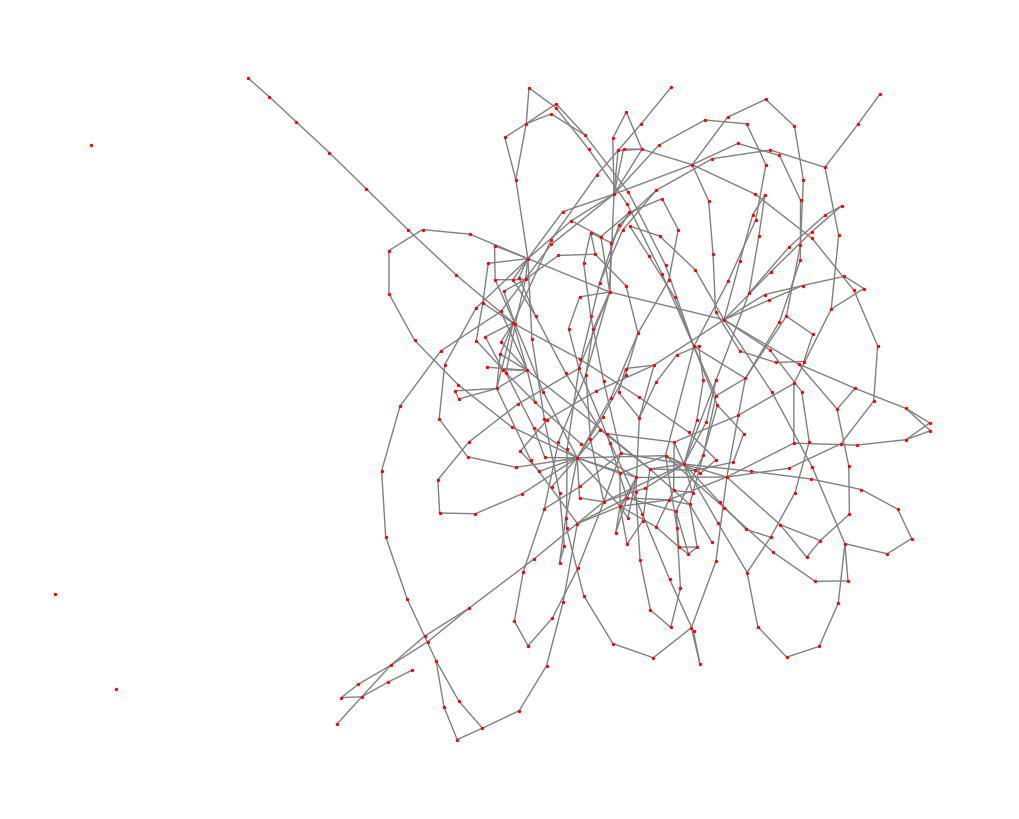

In [229]:
graph_all = nx.read_gml("../../graph_all/final_graph.gml")


print(nx.(graph_all))

plt.figure(figsize=(10, 8))  # Set the figure size
nx.draw(graph_all, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
plt.show()

In [2]:
# add metadata when merging

### FROM PANAROO MERGE_NODES.PY

import itertools
from collections import Counter
#from .isvalid import del_dups
import numpy as np
#from intbitset import intbitset


def gen_node_iterables(G, nodes, feature, split=None):
    for n in nodes:
        if split is None:
            yield G.nodes[n][feature]
        else:
            yield G.nodes[n][feature].split(split)


def gen_edge_iterables(G, edges, feature):
    for e in edges:
        yield G[e[0]][e[1]][feature]


def temp_iter(list_list):
    for n in list_list:
        yield n


def iter_del_dups(iterable):
    seen = {}
    for f in itertools.chain.from_iterable(iterable):
        seen[f] = None
    return (list(seen.keys()))


def del_dups(iterable):
    seen = {}
    for f in iterable:
        seen[f] = None
    return (list(seen.keys()))


def merge_node_cluster(G,
                       nodes,
                       newNode,
                       multi_centroid=True,
                       check_merge_mems=True):

    if check_merge_mems:
        mem_count = Counter(
            itertools.chain.from_iterable(
                gen_node_iterables(G, nodes, 'members')))
        if max(mem_count.values()) > 1:
            raise ValueError("merging nodes with the same genome IDs!")

    # take node with most support as the 'consensus'
    nodes = sorted(nodes, key=lambda x: G.nodes[x]['size'])

    # First create a new node and combine the attributes
    dna = iter_del_dups(gen_node_iterables(G, nodes, 'dna'))
    maxLenId = 0
    max_l = 0
    for i, s in enumerate(dna):
        if len(s) >= max_l:
            max_l = len(s)
            maxLenId = i

    members = G.nodes[nodes[0]]['members'].copy()
    for n in nodes[1:]:
        members |= G.nodes[n]['members']

    if multi_centroid:
        mergedDNA = any(gen_node_iterables(G, nodes, 'mergedDNA'))
    else:
        mergedDNA = True

    G.add_node(
        newNode,
        size=len(members),
        centroid=iter_del_dups(gen_node_iterables(G, nodes, 'centroid')),
        maxLenId=maxLenId,
        members=members,
        seqIDs=set(iter_del_dups(gen_node_iterables(G, nodes, 'seqIDs'))),
        hasEnd=any(gen_node_iterables(G, nodes, 'hasEnd')),
        protein=iter_del_dups(gen_node_iterables(G, nodes, 'protein')),
        dna=dna,
        annotation=";".join(
            iter_del_dups(gen_node_iterables(G, nodes, 'annotation',
                                             split=";"))),
        description=";".join(
            iter_del_dups(
                gen_node_iterables(G, nodes, 'description', split=";"))),
        lengths=list(
            itertools.chain.from_iterable(
                gen_node_iterables(G, nodes, 'lengths'))),
        longCentroidID=max(gen_node_iterables(G, nodes, 'longCentroidID')),
        paralog=any(gen_node_iterables(G, nodes, 'paralog')),
        mergedDNA=mergedDNA)
    if "prevCentroids" in G.nodes[nodes[0]]:
        G.nodes[newNode]['prevCentroids'] = ";".join(
            set(
                iter_del_dups(
                    gen_node_iterables(G, nodes, 'prevCentroids', split=";"))))

    # Now iterate through neighbours of each node and add them to the new node
    merge_nodes = set(nodes)
    for node in nodes:
        for neighbour in G.neighbors(node):
            if neighbour in merge_nodes: continue
            if G.has_edge(newNode, neighbour):
                G[newNode][neighbour]['members'] |= G[node][neighbour][
                    'members']
                G[newNode][neighbour]['size'] = len(G[newNode][neighbour]['members'])
            else:
                G.add_edge(newNode,
                           neighbour,
                           size=G[node][neighbour]['size'],
                           members=G[node][neighbour]['members'])

    # remove old nodes from Graph
    G.remove_nodes_from(nodes)

    return G


def delete_node(G, node):
    # add in new edges
    for mem in G.nodes[node]['members']:
        mem_edges = list(
            set([e[1] for e in G.edges(node) if mem in G.edges[e]['members']]))
        if len(mem_edges) < 2: continue
        for n1, n2 in itertools.combinations(mem_edges, 2):
            if G.has_edge(n1, n2):
                G[n1][n2]['members'] |= intbitset([mem])
                G[n1][n2]['size'] = len(G[n1][n2]['members'])
            else:
                G.add_edge(n1, n2, size=1, members=intbitset([mem]))

    # now remove node
    G.remove_node(node)

    return G


def remove_member_from_node(G, node, member):

    # add in replacement edges if required
    mem_edges = list(
        set([e[1] for e in G.edges(node) if member in G.edges[e]['members']]))
    if len(mem_edges) > 1:
        for n1, n2 in itertools.combinations(mem_edges, 2):
            if G.has_edge(n1, n2):
                G[n1][n2]['members'] |= intbitset([member])
                G[n1][n2]['size'] = len(G[n1][n2]['members'])
            else:
                G.add_edge(n1, n2, size=1, members=intbitset([member]))

    # remove member from node
    G.nodes[node]['members'].discard(member)
    G.nodes[node]['seqIDs'] = set([
        sid for sid in G.nodes[node]['seqIDs']
        if sid.split("_")[0] != str(member)
    ])
    G.nodes[node]['size'] -= 1

    # remove member from edges of node
    edges_to_remove = []
    for e in G.edges(node):
        if member in G.edges[e]['members']:
            if len(G.edges[e]['members']) == 1:
                edges_to_remove.append(e)
            else:
                G.edges[e]['members'].discard(member)
                G.edges[e]['size'] = len(G.edges[e]['members'])
    for e in edges_to_remove:
        G.remove_edge(*e)

    return G

In [13]:
# add metadata (geneIDs)

gene_ids = {}
    centroids_to_nodes = defaultdict(list)
    for cluster in clusters:
        for sid in cluster:
            gene_ids[sid] = cluster[0]
    all_centroids = set(list(gene_ids.values()))
    
for G in graphs:
    for node in G.nodes():
        G.nodes[node]["geneID"] = list(
            set([
                gene_ids[sid] for sid in G.nodes[node]['seqIDs']
                if "refound" not in sid
            ]))
        for sid in G.nodes[node]["centroid"]:
            centroids_to_nodes[sid].append(node)
            
#        G.nodes[node]["dna"] = [
#            centroid_to_seqs[sid][1] for sid in G.nodes[node]["centroid"]
#        ]#
#
#        G.nodes[node]["protein"] = [
#            centroid_to_seqs[sid][0] for sid in G.nodes[node]["centroid"]
#        ]
#        G.nodes[node]["longCentroidID"] = max([
#            (len(seq), sid) for seq, sid in zip(G.nodes[node]["dna"],
#                                                G.nodes[node]["centroid"])
 #       ])

IndentationError: unexpected indent (1206283635.py, line 4)